В домашнем задании, будем обучать разные алгоритмы машинного обучения. Для этого, нужно предварительно зафиксировать схему валидации решения (можете выбрать любую, которую знаете). Выбранную схему валидации нужно использовать во всех задачах этого домашнего задания. Метрика качества - ROC AUC, целевая переменная - isFraud.

Ссылка на данные - https://drive.google.com/file/d/1gMEVl47pIoV1-AseB9doQ6DZNJrY3NkW/view?usp=sharing

- Задание 1: отобрать только числовые признаки и обучить модель XGBoost с параметром booster = gbtree. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

- Задание 2: обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 1.

- Задание 4: для числовых признаков обучить модель LightGBM. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

- Задание 5: обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 4.

- Задание 6: обработать категориальные признаки встроенным методом в LightGBM. Выполнить задание 4. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 5.

- Задание 7: для числовых признаков обучить модель CatBoost. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

- Задание 8: обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 7.

- Задание 9: обработать категориальные признаки встроенным методом в CatBoost. Выполнить задание 7. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 8.

- Задание 10: построить ROC-кривую для всех построенных алгоритмов на обучающей и тестовой выборке. Сделать выводы о работе алгоритмов с точки зрения качества на тестовой выборке и с точки зрения переобучения.

__Задание на повторение:__
Задание не обязательно к выполнению, но очень рекомендуется для понимания набора данных, этот набор данных будет использован и для следующего домашнего задания.

- Задание 1: Построить график распределения времени совершения транзакции для обучающей / тестовой выборки, сделать выводы о том, как разбиты данные и какие виды валидации могут подойти для данной задачи.

- Задание 2: построить scatter-plot зависимости суммы транзакции от времени совершения транзакции. Построить графики для обучающей выборки и для тестовой выборки, для обучающей выборки - построить как для целевой переменной = 0, так и для переменной = 1. Сделать выводы.

- Задание 3: построить распределение признака TransactionAmt в логарифмическом масштабе, сделать выводы о близости распредления к нормальному распределению. Построить распределение признака в логарифмическому масштабе для обучающей выборк и для тестовой выборки, сделать выводы.

- Задание 4: построить распределение признака целевой переменной в зависимости от значений категориальных признаков ProductCD, card4, card6. Сделать выводы.

In [1]:
from typing import List, Optional
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import xgboost as xgb
%matplotlib inline

In [19]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import (roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, \
                             classification_report, plot_confusion_matrix, recall_score, \
                             plot_precision_recall_curve, precision_recall_curve, plot_roc_curve)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
test_path = '/content/drive/MyDrive/Colab Notebooks/Datasets/Kaggle_course/data_HW2/assignment_2_test.csv'

In [5]:
train_path = '/content/drive/MyDrive/Colab Notebooks/Datasets/Kaggle_course/data_HW2/assignment_2_train.csv'

In [6]:
df_train = pd.read_csv(train_path)

In [7]:
df_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df_test = pd.read_csv(test_path)

In [9]:
df_test.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3287000,1,7415038,226.00,W,12473,555.0,150.0,visa,226.0,credit,299.0,87.0,116.0,NaN,aol.com,NaN,2.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0,3.0,2.0,6.0,2.0,4.0,4.0,0.0,4.0,3.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,452.000000,2924.000000,2924.000000,0.0,412.0,0.0,412.0,206.0,412.0,412.0,452.0,2512.0,2512.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3287001,0,7415054,3072.00,W,15651,417.0,150.0,visa,226.0,debit,330.0,87.0,NaN,NaN,yahoo.com,NaN,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,1.0,1.0,0.0,0.0,0.0,1.0,3059.949951,3059.949951,3059.949951,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3059.949951,3059.949951,3059.949951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3287002,0,7415081,319.95,W,13844,583.0,150.0,visa,226.0,credit,126.0,87.0,9.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,1.0,1.0,0.0,0.0,0.0,1.0,319.950012,319.950012,319.950012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,319.950012,319.950012,319.950012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3287003,0,7415111,171.00,W,11556,309.0,150.0,visa,226.0,debit,181.0,87.0,3.0,NaN,anonymous.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,6.0,6.0,6.0,6.0,6.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,59.000000,59.000000,0.0,59.0,0.0,59.0,59.0,59.0,59.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3287004,0,7415112,107.95,W,10985,555.0,150.0,visa,226.0,debit,231.0,87.0,0.0,NaN,anonymous.com,NaN,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,10.0,2.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
target = 'isFraud'

In [11]:
numerical_features_train = df_train.select_dtypes(include=[np.number])
print(f"count of numeric_features {numerical_features_train.shape[1]}")

numerical_features_train.columns

count of numeric_features 380


Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'card5', 'addr1', 'addr2',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=380)

In [12]:
numerical_features_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,4663,490.0,150.0,166.0,330.0,87.0,287.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,18132,567.0,150.0,117.0,476.0,87.0,NaN,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,4497,514.0,150.0,102.0,420.0,87.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
#Задание 1: отобрать только числовые признаки и обучить модель XGBoost с параметром booster = gbtree. 
#Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа
#итераций (выбрать значение самостоятельно).

In [14]:
y_train = numerical_features_train["isFraud"]
x_train = numerical_features_train.drop(["isFraud"], axis=1)

y_valid = df_test["isFraud"]
x_valid = df_test[numerical_features_train.columns].drop(["isFraud"], axis=1)

In [15]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
   # "n_estimators": 1000,
    "reg_lambda": 100,
    "max_depth": 8,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

In [16]:
dtrain = xgb.DMatrix(x_train, y_train)

dvalid = xgb.DMatrix(x_valid, y_valid)

In [17]:
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    early_stopping_rounds=75,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=50,
    maximize=True,
)

[0]	train-auc:0.663359	valid-auc:0.632566
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 75 rounds.
[50]	train-auc:0.899664	valid-auc:0.85171
[100]	train-auc:0.918554	valid-auc:0.858654
[150]	train-auc:0.924102	valid-auc:0.860087
[200]	train-auc:0.924102	valid-auc:0.860087
Stopping. Best iteration:
[127]	train-auc:0.923768	valid-auc:0.860297



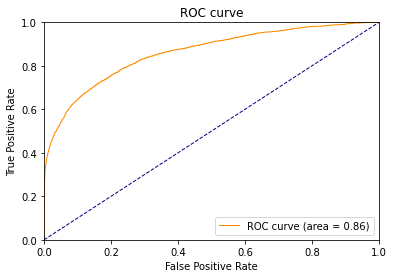

In [20]:
pred_proba_test = model.predict(dvalid)

fpr, tpr, thresholds = roc_curve(y_valid, pred_proba_test)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [21]:
cv_result = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=200,
    stratified=True,
    metrics="auc",
    maximize=True,
    shuffle=True,
    nfold=3
)

In [22]:
cv_result.tail()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
195,0.918133,0.000494,0.903209,0.001971
196,0.918133,0.000494,0.903209,0.001971
197,0.918133,0.000494,0.903209,0.001971
198,0.918133,0.000494,0.903209,0.001971
199,0.918133,0.000494,0.903209,0.001971


## Задание 2. Обработка категориальных признаков

In [23]:
categorical_features = df_train.select_dtypes(include=[np.object])

In [24]:
categorical_features.head()

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,W,discover,credit,NaN,NaN,T,T,T,M2,F,T,NaN,NaN,NaN
1,W,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,W,visa,debit,outlook.com,NaN,T,T,T,M0,F,F,F,F,F
3,W,mastercard,debit,yahoo.com,NaN,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,H,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
categorical_features.ProductCD.unique()

array(['W', 'H', 'C', 'S', 'R'], dtype=object)

__ProductCD__

In [26]:
Product_CD_dict = {
    'W': 1, 
    'H': 2, 
    'C': 3, 
    'S': 4, 
    'R': 5
}

In [27]:
df_train['ProductCD_ord'] = df_train.ProductCD.map(Product_CD_dict)

In [28]:
df_test['ProductCD_ord'] = df_test.ProductCD.map(Product_CD_dict)

__Card4__

In [29]:
categorical_features.card4.unique()

array(['discover', 'mastercard', 'visa', 'american express', nan],
      dtype=object)

In [30]:
df_train['card4'] = df_train.card4.fillna('unknown')
df_test['card4'] = df_test.card4.fillna('unknown')

In [31]:
Card4_dict = {
    'discover': 1, 
    'mastercard': 2, 
    'visa': 3, 
    'american express': 4, 
    'unknown': 5
}

In [32]:
df_train['card4_ord'] = df_train.card4.map(Card4_dict)

In [33]:
df_test['card4_ord'] = df_test.card4.map(Card4_dict)

__Card6__

In [34]:
categorical_features.card6.unique()

array(['credit', 'debit', nan, 'debit or credit', 'charge card'],
      dtype=object)

In [35]:
df_train['card6'] = df_train.card6.fillna('unknown')
df_test['card6'] = df_test.card6.fillna('unknown')

In [36]:
Card6_dict = {
    'credit': 1, 
    'debit': 2, 
    'debit or credit': 3, 
    'charge card': 4, 
    'unknown': 5
}

In [37]:
df_train['card6_ord'] = df_train.card6.map(Card6_dict)

In [38]:
df_test['card6_ord'] = df_test.card6.map(Card6_dict)

__P_emaildomain__

In [39]:
df_train['P_emaildomain'] = df_train.P_emaildomain.fillna('unknown')
df_test['P_emaildomain'] = df_test.P_emaildomain.fillna('unknown')

In [40]:
from sklearn.preprocessing import LabelEncoder

In [41]:
df_train['P_emaildomain_ord'] = LabelEncoder().fit_transform(df_train.P_emaildomain)
df_test['P_emaildomain_ord'] = LabelEncoder().fit_transform(df_test.P_emaildomain)

__R_emaildomain__

In [42]:
df_train['R_emaildomain'] = df_train.R_emaildomain.fillna('unknown')
df_test['R_emaildomain'] = df_test.R_emaildomain.fillna('unknown')

In [43]:
df_train['R_emaildomain_ord'] = LabelEncoder().fit_transform(df_train.R_emaildomain)
df_test['R_emaildomain_ord'] = LabelEncoder().fit_transform(df_test.R_emaildomain)

__M1-M9__

In [44]:
M_dict = {
    'F':0,
    'T':1,
    'unknown':-1
}

In [45]:
M4_dict = {
    'M2':3,
    'M0':4,
    'unknown':6,
    'M1':5
}

In [46]:
df_train['M4'] = df_train.M4.fillna('unknown')
df_test['M4'] = df_test.M4.fillna('unknown')

In [47]:
df_train['M4_ord'] = df_train.M4.map(M4_dict)

In [48]:
df_test['M4_ord'] = df_test.M4.map(M4_dict)

In [49]:
M_features = ['M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9']

In [50]:
for feature in M_features: 
  df_train[feature] = df_train[feature].fillna('unknown')
  df_test[feature] = df_test[feature].fillna('unknown')

In [51]:
for feature in M_features: 
  df_train[feature + '_ord'] = df_test[feature].map(M_dict)
  df_test[feature + '_ord'] = df_test[feature].map(M_dict)

In [52]:
upd_features = categorical_features.columns.to_list()

In [53]:
upd_features = [i+'_ord' for i in categorical_features.columns.to_list()]

In [54]:
upd_features

['ProductCD_ord',
 'card4_ord',
 'card6_ord',
 'P_emaildomain_ord',
 'R_emaildomain_ord',
 'M1_ord',
 'M2_ord',
 'M3_ord',
 'M4_ord',
 'M5_ord',
 'M6_ord',
 'M7_ord',
 'M8_ord',
 'M9_ord']

In [55]:
len(upd_features)

14

In [56]:
df_train[upd_features].head()

,ProductCD_ord,card4_ord,card6_ord,P_emaildomain_ord,R_emaildomain_ord,M1_ord,M2_ord,M3_ord,M4_ord,M5_ord,M6_ord,M7_ord,M8_ord,M9_ord
0,1,1,1,48,49,1.0,1.0,0.0,3,1.0,0.0,0.0,0.0,1.0
1,1,2,1,16,49,-1.0,-1.0,-1.0,4,-1.0,1.0,-1.0,-1.0,-1.0
2,1,3,2,35,49,1.0,1.0,1.0,4,-1.0,1.0,0.0,0.0,1.0
3,1,2,2,54,49,1.0,1.0,1.0,4,1.0,1.0,0.0,1.0,1.0
4,2,2,1,16,49,1.0,1.0,1.0,6,-1.0,1.0,1.0,1.0,1.0


In [57]:
df_test[upd_features].head()

,ProductCD_ord,card4_ord,card6_ord,P_emaildomain_ord,R_emaildomain_ord,M1_ord,M2_ord,M3_ord,M4_ord,M5_ord,M6_ord,M7_ord,M8_ord,M9_ord
0,1,3,1,2,45,1,1,0,4,1,0,0,0,1
1,1,3,2,54,45,-1,-1,-1,6,-1,1,-1,-1,-1
2,1,3,1,16,45,1,1,1,6,-1,1,0,0,1
3,1,3,2,1,45,1,1,1,4,1,1,0,1,1
4,1,3,2,1,45,1,1,1,6,-1,1,1,1,1


In [58]:
#добавим обработанные категориальные признаки к числовым и заново обучим модель.

In [59]:
num_list = numerical_features_train.columns.to_list()

In [60]:
for feature in upd_features:
  num_list.append(feature)

In [ ]:
# Обучим xgboost 

In [61]:
y_train_cat = df_train["isFraud"]
x_train_cat = df_train[num_list].drop(["isFraud"], axis = 1)

y_valid_cat = df_test["isFraud"]
x_valid_cat = df_test[num_list].drop(["isFraud"], axis = 1)

In [62]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
   # "n_estimators": 1000,
    "reg_lambda": 100,
    "max_depth": 8,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

In [63]:
dtrain_cat = xgb.DMatrix(x_train_cat, y_train_cat)

dvalid_cat = xgb.DMatrix(x_valid_cat, y_valid_cat)

In [64]:
model_with_cat = xgb.train(
    params=params,
    dtrain=dtrain_cat,
    num_boost_round=500,
    early_stopping_rounds=75,
    evals=[(dtrain_cat, "train"), (dvalid_cat, "valid")],
    verbose_eval=50,
    maximize=True,
)

[0]	train-auc:0.663359	valid-auc:0.632566
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 75 rounds.
[50]	train-auc:0.901659	valid-auc:0.860343
[100]	train-auc:0.924492	valid-auc:0.865482
[150]	train-auc:0.930427	valid-auc:0.867616
[200]	train-auc:0.930427	valid-auc:0.867616
Stopping. Best iteration:
[135]	train-auc:0.930339	valid-auc:0.867694



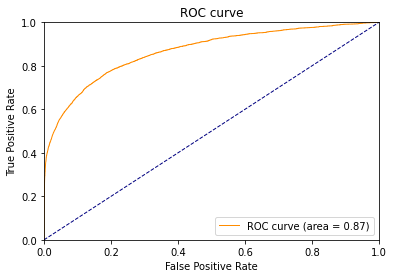

In [67]:
pred_proba_test2 = model_with_cat.predict(dvalid_cat)

fpr, tpr, thresholds = roc_curve(y_valid_cat, pred_proba_test2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#Без категориальных признаков:
#Stopping. Best iteration:
#[127]	train-auc:0.923768	valid-auc:0.860297

In [ ]:
#С категориальными признаками: 
#[135]	train-auc:0.930339	valid-auc:0.867694

In [ ]:
cv_result_w_cat = xgb.cv(
    params=params,
    dtrain=dtrain_cat,
    num_boost_round=200,
    stratified=True,
    metrics="auc",
    maximize=True,
    shuffle=True,
    nfold=3
)

In [ ]:
cv_result_w_cat.tail()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
195,0.92336,0.001763,0.90896,0.001872
196,0.92336,0.001763,0.90896,0.001872
197,0.92336,0.001763,0.90896,0.001872
198,0.92336,0.001763,0.90896,0.001872
199,0.92336,0.001763,0.90896,0.001872


In [ ]:
# без категориальных переменных: 199	0.918133	0.000494	0.903209	0.001971
# с категориальными переменными: 199	0.92336	0.001763	0.90896	0.001872

In [ ]:
#Поскольку ОЗУ в колабе не выдерживает, то продолжаем выполнение ДЗ в другом колабе. 

In [68]:
#Задание 10. Графики построены выше. Для алгоритма с категориальными переменными алгоритм улучшился на 1%.